In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle
from matplotlib.animation import FuncAnimation 


import tensorflow
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, Flatten, MaxPooling1D, Conv1D, GlobalAveragePooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

dotrain = True
dotest = True
doanim = False

epochs = 500
batch_size = 32

dense_numunits = 16
conv1d_numunits = 32
simplernn_numunits = 16
lstm_numunits = 16

history_length = 6
forecast_length = 24

np.random.seed(237)
tensorflow.random.set_seed(237)

In [2]:
def build_window(data, h, f):
    
    dataX, dataY = [], []
    
    for i in range(len(data)-h-f):
        dataX.append(data[i:(i+h)])
        dataY.append(data[(i+h):(i+h+f)])
        
    dataX = np.array(dataX)
    dataX = np.reshape(dataX, (dataX.shape[0], 1, dataX.shape[1]))
    
    dataY = np.array(dataY)
    
    return dataX, dataY

# Load data

In [3]:
Y = pd.DataFrame()

folder = 'C:/Projects/Professional_Certificate_in_ML_and_AI/Module23/Notebooks_starter/traffic/'

prefix = '2018/flow_station_1209204_2018_'
for i in range(1,12):
    filename = '{}{}{:02d}'.format(folder,prefix,i)
    with open(filename,'rb') as f:
        X = pickle.load(f)
        X.set_index(pd.to_datetime(X['Timestamp']),inplace=True)
        X.drop(columns=['Timestamp'],inplace=True)
        Y = Y.append(X)
        
prefix = '2019/flow_station_1209204_2019_'
for i in range(1,12):
    filename = '{}{}{:02d}'.format(folder,prefix,i)
    with open(filename,'rb') as f:
        X = pickle.load(f)
        X.set_index(pd.to_datetime(X['Timestamp']),inplace=True)
        X.drop(columns=['Timestamp'],inplace=True)
        Y = Y.append(X)
        
raw_data = Y['Total Flow'].values
data = raw_data

C:\Users\Plamen\AppData\Local\Temp\ipykernel_24692\1430360524.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Y = Y.append(X)
C:\Users\Plamen\AppData\Local\Temp\ipykernel_24692\1430360524.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Y = Y.append(X)
C:\Users\Plamen\AppData\Local\Temp\ipykernel_24692\1430360524.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Y = Y.append(X)
C:\Users\Plamen\AppData\Local\Temp\ipykernel_24692\1430360524.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Y = Y.append(X)
C:\Users\Plamen\AppData\Local\Temp\ipykernel_24692\1430360524.py:12: FutureWarning: The frame.append method is deprecate

# Scale the data

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
raw_data = scaler.fit_transform(raw_data.reshape(-1, 1))

Text(0.5, 0, 'Hours')

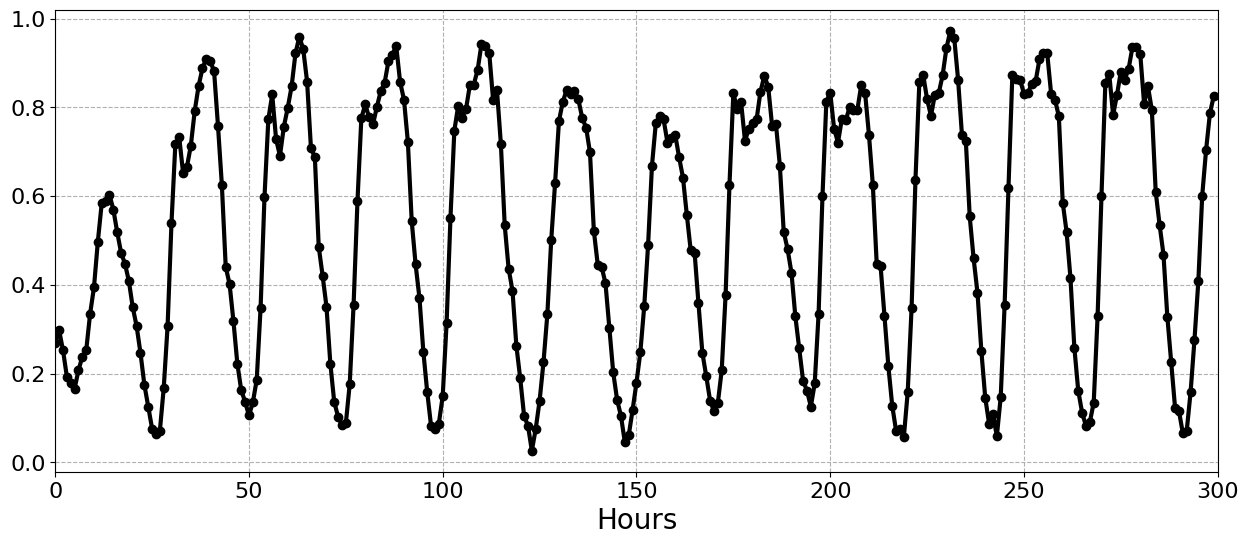

In [5]:
plt.figure(figsize=(15,6))
plt.plot(raw_data[:300],'ko-',linewidth=3)
plt.grid(linestyle='--')
plt.xlim(0,300)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Hours',fontsize=20)
# plt.ylabel('MSE',fontsize=20,rotation=0, labelpad=40)

# Train/test data

In [6]:
dataX, dataY = build_window(data, history_length, forecast_length)
data.shape, dataX.shape, dataY.shape

((13980,), (13950, 1, 6), (13950, 24))

In [7]:
num_train_samples = int(0.8 * len(raw_data))
trainX, trainY = dataX[:num_train_samples,:,:], dataY[:num_train_samples,:]
valX,  valY    = dataX[num_train_samples:,:,:], dataY[num_train_samples:,:]
trainX.shape, trainY.shape, valX.shape,  valY.shape

((11184, 1, 6), (11184, 24), (2766, 1, 6), (2766, 24))

# DENSE 

In [8]:
model_dense = Sequential()
model_dense.add(Flatten())
model_dense.add(Dense(16, activation="relu"))
model_dense.add(Dense(24))

In [9]:


model_dense.compile(loss="mse", metrics=["mae"], optimizer="adam")

history_dense = model_dense.fit(trainX, trainY, epochs=500, batch_size=32, validation_data = (valX, valY) )

Epoch 1/500
350/350 [==============================] - 1s 1ms/step - loss: 23181430.0000 - mae: 3720.8752 - val_loss: 10468770.0000 - val_mae: 2544.5820
Epoch 2/500
350/350 [==============================] - 0s 894us/step - loss: 8079842.0000 - mae: 2187.0056 - val_loss: 6049500.0000 - val_mae: 1884.3835
Epoch 3/500
350/350 [==============================] - 0s 865us/step - loss: 5265223.5000 - mae: 1722.4801 - val_loss: 4928505.5000 - val_mae: 1660.6060
Epoch 4/500
350/350 [==============================] - 0s 948us/step - loss: 4494367.0000 - mae: 1575.5022 - val_loss: 4546939.5000 - val_mae: 1584.8259
Epoch 5/500
350/350 [==============================] - 0s 872us/step - loss: 4165059.2500 - mae: 1511.7789 - val_loss: 4314197.0000 - val_mae: 1530.1106
Epoch 6/500
350/350 [==============================] - 0s 875us/step - loss: 3944494.2500 - mae: 1466.0857 - val_loss: 4176437.7500 - val_mae: 1489.9050
Epoch 7/500
350/350 [==============================] - 0s 902us/step - loss: 37927

In [10]:
model_dense = Sequential()
model_dense.add(Flatten())
model_dense.add(Dense(dense_numunits, activation="relu"))
model_dense.add(Dense(forecast_length))

model_dense.compile(loss="mse", metrics=["mae"], optimizer="adam")

history_dense = model_dense.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, validation_data = (valX, valY), verbose=0)

model_dense.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 6)                 0         
                                                                 
 dense_2 (Dense)             (None, 16)                112       
                                                                 
 dense_3 (Dense)             (None, 24)                408       
                                                                 
Total params: 520 (2.03 KB)
Trainable params: 520 (2.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# SimpRNN

In [11]:
model_simprnn = Sequential()
model_simprnn.add(SimpleRNN(16, input_shape=(1,6)))             
model_simprnn.add(Dense(24))

In [12]:
model_simprnn.compile(loss="mse", metrics=["mae"], optimizer="adam")

history_simprnn = model_simprnn.fit(trainX, trainY, epochs=500, batch_size=32, validation_data = (valX, valY) )

Epoch 1/500
350/350 [==============================] - 1s 2ms/step - loss: 60876224.0000 - mae: 7219.2446 - val_loss: 55036036.0000 - val_mae: 6804.7954
Epoch 2/500
350/350 [==============================] - 0s 1ms/step - loss: 60787820.0000 - mae: 7213.1094 - val_loss: 54951444.0000 - val_mae: 6798.5713
Epoch 3/500
350/350 [==============================] - 0s 1ms/step - loss: 60697604.0000 - mae: 7206.8584 - val_loss: 54866600.0000 - val_mae: 6792.3291
Epoch 4/500
350/350 [==============================] - 0s 1ms/step - loss: 60609820.0000 - mae: 7200.7588 - val_loss: 54784952.0000 - val_mae: 6786.3169
Epoch 5/500
350/350 [==============================] - 0s 996us/step - loss: 60523340.0000 - mae: 7194.7520 - val_loss: 54703808.0000 - val_mae: 6780.3340
Epoch 6/500
350/350 [==============================] - 0s 1ms/step - loss: 60437548.0000 - mae: 7188.7881 - val_loss: 54623304.0000 - val_mae: 6774.3950
Epoch 7/500
350/350 [==============================] - 0s 1ms/step - loss: 60352

In [13]:
model_simprnn = Sequential()
model_simprnn.add(SimpleRNN(simplernn_numunits, input_shape=(1,history_length)))             
model_simprnn.add(Dense(forecast_length))

model_simprnn.compile(loss="mse", metrics=["mae"], optimizer="adam")

history_simprnn = model_simprnn.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, validation_data = (valX, valY), verbose=0)

model_simprnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 16)                368       
                                                                 
 dense_5 (Dense)             (None, 24)                408       
                                                                 
Total params: 776 (3.03 KB)
Trainable params: 776 (3.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# LSTM

In [14]:
model_lstm = Sequential()
model_lstm.add(LSTM(16, input_shape=(1, 6)))
model_lstm.add(Dense(24))

In [15]:
model_lstm.compile(loss='mse', metrics=["mae"])

history = model_lstm.fit(trainX, trainY, epochs=500, batch_size=32, validation_data = (valX, valY) )

Epoch 1/500
350/350 [==============================] - 2s 2ms/step - loss: 60903484.0000 - mae: 7221.1201 - val_loss: 55084068.0000 - val_mae: 6808.3208
Epoch 2/500
350/350 [==============================] - 0s 1ms/step - loss: 60864192.0000 - mae: 7218.4048 - val_loss: 55046800.0000 - val_mae: 6805.5820
Epoch 3/500
350/350 [==============================] - 0s 1ms/step - loss: 60824656.0000 - mae: 7215.6675 - val_loss: 55009492.0000 - val_mae: 6802.8423
Epoch 4/500
350/350 [==============================] - 0s 1ms/step - loss: 60784956.0000 - mae: 7212.9111 - val_loss: 54971928.0000 - val_mae: 6800.0767
Epoch 5/500
350/350 [==============================] - 0s 1ms/step - loss: 60744308.0000 - mae: 7210.0938 - val_loss: 54934072.0000 - val_mae: 6797.2905
Epoch 6/500
350/350 [==============================] - 0s 1ms/step - loss: 60703856.0000 - mae: 7207.2861 - val_loss: 54894976.0000 - val_mae: 6794.4199
Epoch 7/500
350/350 [==============================] - 0s 1ms/step - loss: 6066398

In [16]:
model_lstm = Sequential()
model_lstm.add(LSTM(lstm_numunits, input_shape=(1, history_length)))
model_lstm.add(Dense(forecast_length))

model_lstm.compile(loss='mse', metrics=["mae"], optimizer='adam')

history_lstm = model_lstm.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, validation_data = (valX, valY), verbose=0)

model_lstm.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 16)                1472      
                                                                 
 dense_7 (Dense)             (None, 24)                408       
                                                                 
Total params: 1880 (7.34 KB)
Trainable params: 1880 (7.34 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# PLOT

Text(0, 0.5, 'MSE')

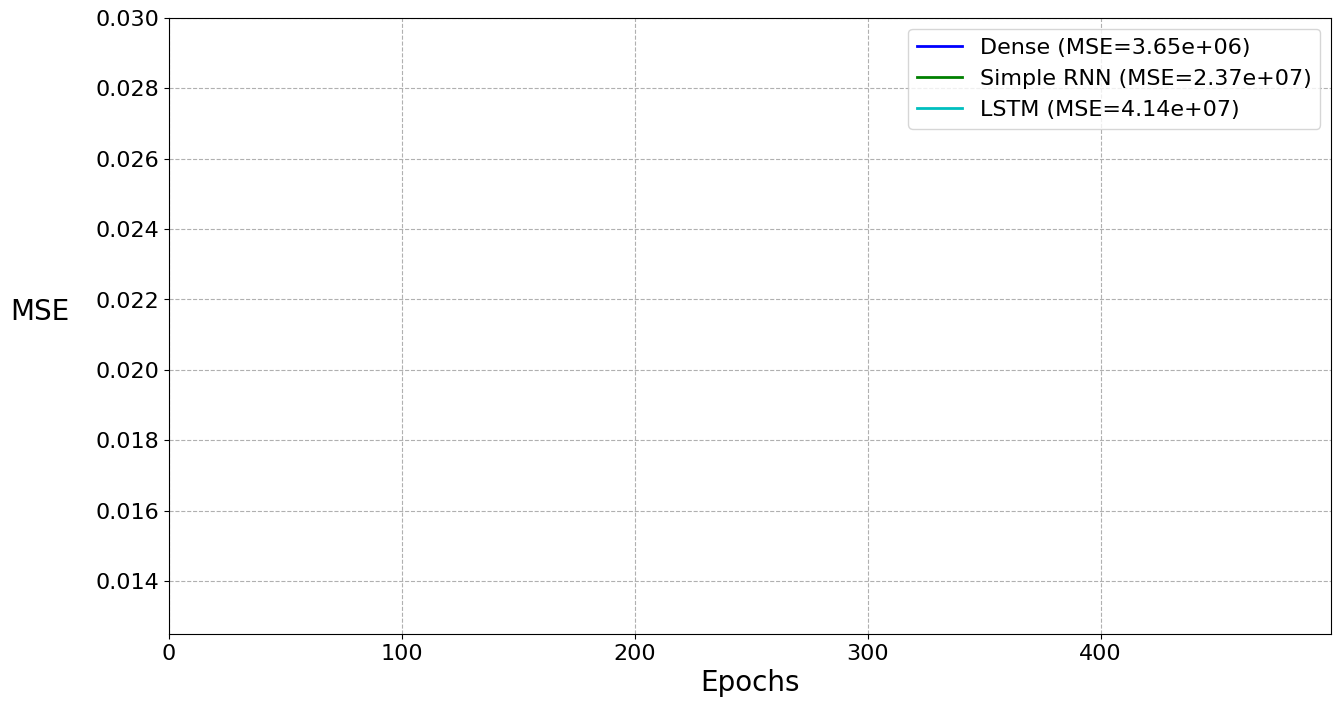

In [17]:
e = range(epochs)

mse_dense = np.mean(history_dense.history['val_loss'][-5:-1])
mse_simprnn = np.mean(history_simprnn.history['val_loss'][-5:-1])
mse_lstm = np.mean(history_lstm.history['val_loss'][-5:-1])


plt.figure(figsize=(15,8))
plt.plot(e,history_dense.history['loss'], 'b--', linewidth=2)
plt.plot(e,history_dense.history['val_loss'], 'b-', linewidth=2,label='Dense (MSE={:.2e})'.format(mse_dense))
plt.plot(e,history_simprnn.history['loss'], 'g--', linewidth=2)
plt.plot(e,history_simprnn.history['val_loss'], 'g-', linewidth=2,label='Simple RNN (MSE={:.2e})'.format(mse_simprnn))
plt.plot(e,history_lstm.history['loss'], 'c--', linewidth=2)
plt.plot(e,history_lstm.history['val_loss'], 'c-', linewidth=2, label='LSTM (MSE={:.2e})'.format(mse_lstm))
plt.xlim(0,epochs-1)
plt.ylim(0.0125,0.03)
plt.legend(fontsize=16)
plt.grid(linestyle='--')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('MSE',fontsize=20,rotation=0, labelpad=40)

# Animation

In [18]:
if doanim:
    
    tx0 = history_length-1 + np.arange(forecast_length+1)
    tx1 = np.arange(30)
    tx2 = np.arange(history_length)
    ty = history_length + np.arange(forecast_length)
    ind = 4

    ypred_lstm = scaler.inverse_transform(model_lstm.predict(valX))
    ypred_simprnn = scaler.inverse_transform(model_simprnn.predict(valX))
    ypred_dense = scaler.inverse_transform(model_dense.predict(valX))
    # raw_data_ = scaler.inverse_transform(raw_data)

    fig = plt.figure(figsize=(12,6)) 
    axis = plt.axes(xlim =(0, 30),ylim=(0,11662)) 

    line0, = axis.plot([], [],':', color=[.1,.1,.1], lw = 1) 
    line1, = axis.plot([], [],'ko-', lw = 3) 
    line4, = axis.plot([], [],'bo-', lw = 2, label='Dense') 
    line3, = axis.plot([], [],'go-', lw = 2, label='Simple RNN') 
    line2, = axis.plot([], [],'co-', lw = 2, label='LSTM') 
    plt.grid(linestyle='--')
    plt.legend(fontsize=14,loc='lower left')
    plt.xticks([])

    def init(): 
        line0.set_data([], [])
        line1.set_data([], [])
        line2.set_data([], [])
        line3.set_data([], [])
        line4.set_data([], [])
        return line0, line1, line2, line3, line4

    def animate(i):
        x = raw_data[i+num_train_samples+history_length-1:i+num_train_samples+history_length+forecast_length]
        line0.set_data(tx0,x)
        line1.set_data(tx2,scaler.inverse_transform(valX[i]))
        line2.set_data(ty,ypred_lstm[i])
        line3.set_data(ty,ypred_simprnn[i])
        line4.set_data(ty,ypred_dense[i])
        return line1, line2, line3, line4

    anim = FuncAnimation(fig, animate, init_func = init, frames = 2000, interval = 20, blit = True)

    anim.save('flow_pred.mp4', writer = 'ffmpeg', fps = 10)